In [7]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
from matplotlib.ticker import MultipleLocator
from astropy.visualization import simple_norm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

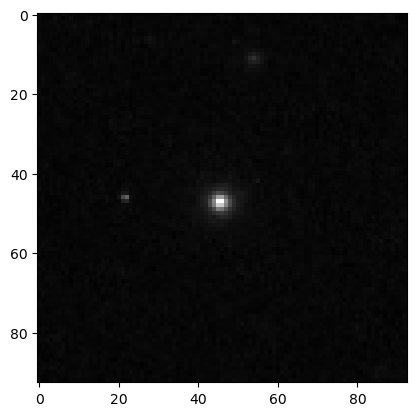

In [44]:
d = fits.open("/Users/gavin/Downloads/galfit-example/EXAMPLE/gal.fits")
plt.imshow(d[0].data, cmap = 'gray')

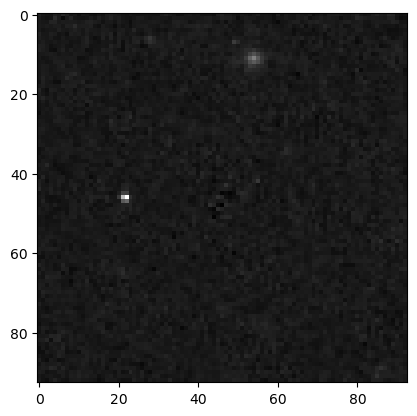

In [53]:
d = fits.open("/Users/gavin/Downloads/galfit-example/EXAMPLE/imgblock.fits")
plt.imshow(d[3].data, cmap = 'gray')

# Run galfit

Take a look at config file: CEERS_AGN_demo/galfit_F200W.feedme for input images and model setup

In [6]:
os.system('galfit CEERS_AGN_demo/galfit_F200W.feedme')


GALFIT Version 3.0.5 -- Apr. 23, 2013






#  Input menu file: CEERS_AGN_demo/galfit_F200W.feedme


# IMAGE and GALFIT CONTROL PARAMETERS
A) CEERS_AGN_demo/DATA_F200W.fits      # Input data image (FITS file)
B) CEERS_AGN_demo/results_F200W.fits      # Output data image block
C) none                # Sigma image name (made from data if blank or "none") 
D) CEERS_AGN_demo/PSF_MODEL_F200W.fits #        # Input PSF image and (optional) diffusion kernel
E) 2                   # PSF fine sampling factor relative to data 
F) CEERS_AGN_demo/MASK.fits      # Bad pixel mask (FITS image or ASCII coord list)
G) CEERS_AGN_demo/galfit_SS.CONSTRAINTS      # File with parameter constraints (ASCII file) 
H) 1    201  1    201  # Image region to fit (xmin xmax ymin ymax)
I) 151    151          # Size of the convolution box (x y)
J) 27.394              # Magnitude photometric zeropoint 
K) 0.030  0.030        # Plate scale (dx dy)   [arcsec per pixel]
O) regular             # Display type (regular, cur

0

Results are saved to a file called results_F200W.fits in the CEERS_AGN_demo folder

Edit galfit.01 file and change option P) from 0 to 3 to generate image for each component. Execute the following command:

In [54]:
os.system('galfit galfit.01')


GALFIT Version 3.0.5 -- Apr. 23, 2013






#  Input menu file: galfit.01


# IMAGE and GALFIT CONTROL PARAMETERS
A) CEERS_AGN_demo/DATA_F200W.fits      # Input data image (FITS file)
B) CEERS_AGN_demo/results_F200W.fits      # Output data image block
C) none                # Sigma image name (made from data if blank or "none") 
D) CEERS_AGN_demo/PSF_MODEL_F200W.fits #        # Input PSF image and (optional) diffusion kernel
E) 2                   # PSF fine sampling factor relative to data 
F) CEERS_AGN_demo/MASK.fits      # Bad pixel mask (FITS image or ASCII coord list)
G) CEERS_AGN_demo/galfit_SS.CONSTRAINTS      # File with parameter constraints (ASCII file) 
H) 1    201  1    201  # Image region to fit (xmin xmax ymin ymax)
I) 151    151          # Size of the convolution box (x y)
J) 27.394              # Magnitude photometric zeropoint 
K) 0.030  0.030        # Plate scale (dx dy)   [arcsec per pixel]
O) regular             # Display type (regular, curses, both)
P) 3          

0

Subcomponents are saved to subcomps.fits

# Plot fitting results

In [55]:
# cosmology
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [56]:
# Source information
objname = 'SDSS1420+5300A'
z = 1.646
# Separation in transverse proper kpc corresponding to 1 arcsec at redshift ``z``
kpc_arcsec = cosmo.kpc_proper_per_arcmin(z).value / 60

# pixel scale of this image is 0.03 arcsec/pixel
pixelscale = 0.03

# best-fit parameters in the F200W filter
header = fits.getheader('CEERS_AGN_demo/results_F200W.fits', 2)
n = float(header['3_N'].split(' ')[0])  # sersic index
Re = float(header['3_RE'].split(' ')[0])  # effective radius (pixel)  1 pixel = 0.03 arcsec
m_AGN = float(header['2_MAG'].split(' ')[0])  # mag
m_host = float(header['3_MAG'].split(' ')[0])  # mag
f_host = 10**(-0.4*m_host)/(10**(-0.4*m_host)+10**(-0.4*m_AGN))  # host-to-total flux fraction

# load data and model
data_F200W = fits.getdata('CEERS_AGN_demo/DATA_F200W.fits')
header = fits.getheader('CEERS_AGN_demo/DATA_F200W.fits')
EXPTIME = header['EXPTIME']  # exposure time
MAG_ZP = header['MAG_ZP']  # magnitude zeropoint
residual_F200W = fits.getdata('CEERS_AGN_demo/results_F200W.fits', 3)
sky_F200W = fits.getdata('subcomps.fits', 1)
psf_F200W = fits.getdata('subcomps.fits', 2)
sersic_F200W = fits.getdata('subcomps.fits', 3)
companion_F200W = fits.getdata('subcomps.fits', 4)
model_F200W = psf_F200W+sersic_F200W+companion_F200W  # total (AGN+host+companion) model
shape = data_F200W.shape
# ellipse fitting
r_F200W = Table.read('CEERS_AGN_demo/DATA_F200W.csv')  # data
r1_F200W = Table.read('CEERS_AGN_demo/COMP_PSF_F200W.csv')  # AGN
r2_F200W = Table.read('CEERS_AGN_demo/COMP_SERSIC_F200W.csv')  # host


In [57]:
def show_ellipse(ax, data_isolist, psf_isolist, sersic_isolist, exptime, z=None, xlabel=False,
                 ylabel=False, zeromag=28.087, pixelscale=0.03, legend=False, name=None):
    divider = make_axes_locatable(ax)

    ax2 = divider.new_vertical(size="400%", pad=0.0)
    fig1 = ax.get_figure()
    fig1.add_axes(ax2)

    x = data_isolist['sma']*pixelscale

    mag = -2.5*np.log10(data_isolist['intens']/exptime/(np.pi*pixelscale**2)) + zeromag
    mag_e = data_isolist['intens_err']/data_isolist['intens']*0.4343*2.5
    fltr = mag == np.inf
    mag[fltr] = np.nan
    xlim = [0.015, 1.5]

    mag2 = -2.5*np.log10(psf_isolist['intens']/exptime/(np.pi*pixelscale**2)) + zeromag
    mag3 = -2.5*np.log10(sersic_isolist['intens']/exptime/(np.pi*pixelscale**2)) + zeromag
    mag4 = -2.5*np.log10(10**(-0.4*mag2)+10**(-0.4*mag3))

    ylim = [15.5, 28.5]

    ax2.errorbar(x, mag, yerr=mag_e, marker='o', mfc='none', ls='none', label='Data',
                 color='k', ms=15, elinewidth=1, mew=1, zorder=0)
    ax2.errorbar(psf_isolist['sma']*pixelscale, mag4, marker=None, mfc='none', ls='--', label='Model', color='m', lw=2, zorder=1)
    ax2.errorbar(psf_isolist['sma']*pixelscale, mag2, marker=None, mfc='none', ls='--', label='PSF', color='b', lw=2, zorder=2)
    ax2.errorbar(psf_isolist['sma']*pixelscale, mag3, marker=None, mfc='none', ls='--', label="${\\rm S\\'{e}rsic}$", color='r', lw=2, zorder=3)
    ax2.set_xscale('log')
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    if legend:
        ax2.legend(loc='lower left', bbox_to_anchor=(0.01, 0.01), numpoints=1, scatterpoints=1, fontsize=24,
                   framealpha=0.6, handlelength=0.8, handletextpad=0.5)
    ax2.invert_yaxis()
    ax2.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax2.xaxis.set_tick_params(which="major", labelsize=23, length=12, width=2)
    ax2.xaxis.set_tick_params(which="minor", length=8, width=2)
    ax2.yaxis.set_tick_params(which="major", labelsize=23, length=12, width=2)
    ax2.yaxis.set_tick_params(which="minor", length=8, width=2)
    if name != None:
        ax2.text(0.97, 0.95, '{}'.format(name.replace('-', '$-$')), verticalalignment='top',
            horizontalalignment='right', transform=ax2.transAxes,
             fontsize=32, bbox=dict(facecolor='white', alpha=0.1, edgecolor="none"))
        ax2.text(0.97, 0.8, ' $z={:.3f}$'.format(z), verticalalignment='top',
            horizontalalignment='right', transform=ax2.transAxes,
             fontsize=32, bbox=dict(facecolor='white', alpha=0.1, edgecolor="none"))

    ax.errorbar(x, mag-mag4, yerr=mag_e, marker='o', mfc='none', ls='none',
                color='k', ms=15, elinewidth=1, mew=1)
    ax.plot([-0.1, 100], [0, 0], ls='-', color='k', label=None)
    ax.set_xscale('log')
    ax.set_xlim(xlim)
    if xlabel:
        ax.set_xlabel('Semi-major radius (arcsec)', fontsize=32, labelpad=3)
    else:
        plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_ylim([-0.7, 0.7])
    ax.set_yticks([-0.5, 0, 0.5])
    ax.xaxis.set_tick_params(which="major", labelsize=23, length=8, width=2)
    ax.xaxis.set_tick_params(which="minor", length=5, width=2)
    ax.yaxis.set_tick_params(which="major", labelsize=23, length=8, width=2)
    ax.yaxis.set_tick_params(which="minor", length=5, width=2)
    if ylabel:
        ax2.set_ylabel('$\\mu$ (mag arcsec$^{-2}$)', fontsize=32)
        ax.set_ylabel('$\\Delta \\mu$', fontsize=32, labelpad=-3)
    for tl in ax2.get_xticklabels():
        tl.set_visible(False)


/var/folders/3_/596gx0f10xg46rczf6hpm5bm0000gn/T/ipykernel_17536/62654913.py:17: RuntimeWarning: divide by zero encountered in log10
  mag2 = -2.5*np.log10(psf_isolist['intens']/exptime/(np.pi*pixelscale**2)) + zeromag
/var/folders/3_/596gx0f10xg46rczf6hpm5bm0000gn/T/ipykernel_17536/62654913.py:17: RuntimeWarning: invalid value encountered in log10
  mag2 = -2.5*np.log10(psf_isolist['intens']/exptime/(np.pi*pixelscale**2)) + zeromag


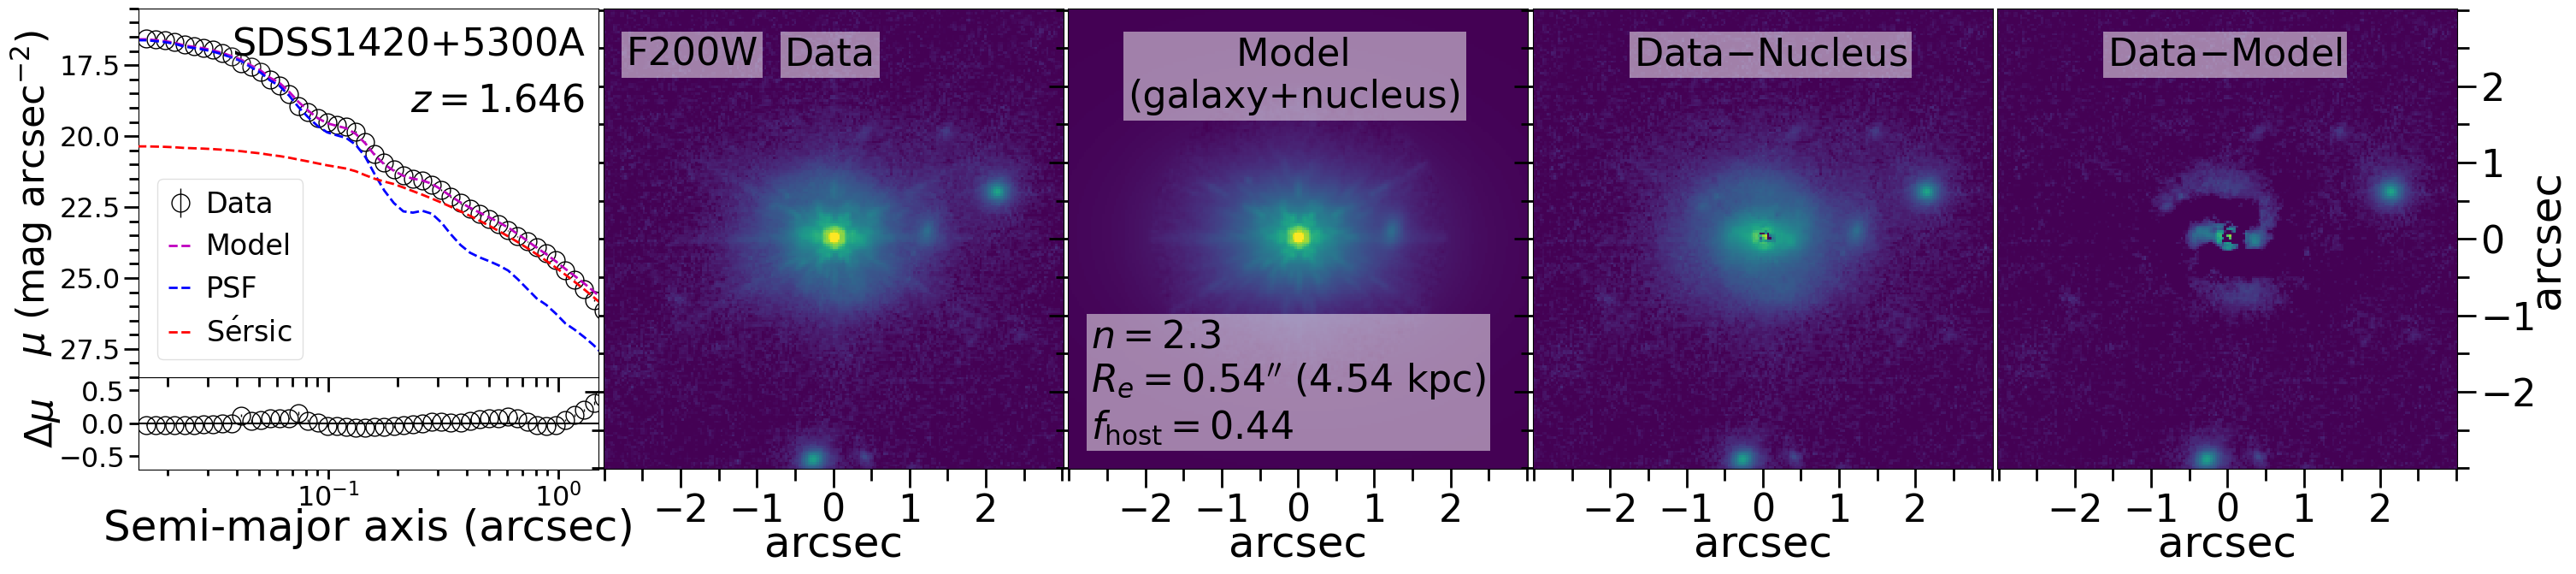

In [58]:

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(35, 7))
plt.subplots_adjust(wspace=0.01)
# plt.subplots_adjust(hspace=0.01)
ax = ax.ravel()
ax0 = ax[0]
ax1 = ax[1]
ax2 = ax[2]
ax3 = ax[3]
ax4 = ax[4]

show_ellipse(ax=ax0, data_isolist=r_F200W, psf_isolist=r1_F200W, sersic_isolist=r2_F200W, zeromag=MAG_ZP,
             exptime=EXPTIME, ylabel=True, legend=True, xlabel=True, name=objname, z=z, pixelscale=pixelscale)
norm1 = simple_norm([0, 0.2 * np.max(model_F200W)], 'log', percent=100)
ax1.imshow(data_F200W - sky_F200W, cmap='viridis', origin='lower', norm=norm1,
            extent=[-shape[0] * pixelscale / 2, shape[0] * pixelscale / 2, -shape[0] * pixelscale / 2, shape[0] * pixelscale / 2],
            interpolation='nearest')
ax1.text(0.05, 0.94, 'F200W', verticalalignment='top',
         horizontalalignment='left', transform=ax1.transAxes,
         fontsize=32, bbox=dict(facecolor='white', alpha=0.5, edgecolor="none"))
ax1.text(0.395, 0.94, 'Data', verticalalignment='top',
         horizontalalignment='left', transform=ax1.transAxes,
         fontsize=32, bbox=dict(facecolor='white', alpha=0.5, edgecolor="none"))
ax2.text(0.13, 0.94, '         Model\n(galaxy+nucleus)', verticalalignment='top',
         horizontalalignment='left', transform=ax2.transAxes,
         fontsize=32, bbox=dict(facecolor='white', alpha=0.5, edgecolor="none"))

ax2.text(0.05, 0.05, '$n={:.1f}$\n'.format(n) + '$R_e={:.2f}$'.format(Re * pixelscale) +
         '$^{\\prime\\prime}$ '+ '({:.2f} kpc)\n'.format(kpc_arcsec*Re * pixelscale) +
         '$f_{\\rm host}=' + '{:.2f}$'.format(f_host),
         verticalalignment='bottom', horizontalalignment='left', transform=ax2.transAxes,
         fontsize=32, bbox=dict(facecolor='white', alpha=0.5, edgecolor="none"))

ax3.text(0.22, 0.94, 'Data$-$Nucleus', verticalalignment='top',
         horizontalalignment='left', transform=ax3.transAxes,
         fontsize=32, bbox=dict(facecolor='white', alpha=0.5, edgecolor="none"))
ax4.text(0.24, 0.94, 'Data$-$Model', verticalalignment='top',
         horizontalalignment='left', transform=ax4.transAxes,
         fontsize=32, bbox=dict(facecolor='white', alpha=0.5, edgecolor="none"))

ax2.imshow(model_F200W - np.mean(sky_F200W), cmap='viridis', origin='lower', norm=norm1,
            extent=[-shape[0] * pixelscale / 2, shape[0] * pixelscale / 2, -shape[0] * pixelscale / 2, shape[0] * pixelscale / 2],
            interpolation='nearest')
ax3.imshow(data_F200W - psf_F200W - sky_F200W, cmap='viridis', origin='lower', norm=norm1,
            extent=[-shape[0] * pixelscale / 2, shape[0] * pixelscale / 2, -shape[0] * pixelscale / 2, shape[0] * pixelscale / 2],
            interpolation='nearest')
ax4.imshow(residual_F200W, cmap='viridis', origin='lower', norm=norm1,
            extent=[-shape[0] * pixelscale / 2, shape[0] * pixelscale / 2, -shape[0] * pixelscale / 2, shape[0] * pixelscale / 2],
            interpolation='nearest')
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
tticks = [-2, -1, 0, 1, 2]
minor_tick = 0.5
for dd in [ax1, ax2, ax3, ax4]:
    dd.set_yticks(tticks)
    dd.set_xticks(tticks)
    dd.set_xlim([-shape[0] * pixelscale / 2, shape[0] * pixelscale / 2])
    dd.set_ylim([-shape[0] * pixelscale / 2, shape[0] * pixelscale / 2])
    dd.xaxis.set_minor_locator(MultipleLocator(minor_tick))
    dd.yaxis.set_minor_locator(MultipleLocator(minor_tick))
    dd.xaxis.set_tick_params(which="major", labelsize=32, length=16, width=2)
    dd.xaxis.set_tick_params(which="minor", length=10, width=2)
    dd.yaxis.set_tick_params(which="major", labelsize=32, length=16, width=2)
    dd.yaxis.set_tick_params(which="minor", length=10, width=2)

yticklabels = ax2.get_yticklabels() + ax3.get_yticklabels() + ax1.get_yticklabels()
plt.setp(yticklabels, visible=False)

ax0.set_xlabel('Semi-major axis (arcsec)', fontsize=36, labelpad=-4)
ax1.set_xlabel('arcsec', fontsize=36, labelpad=-4)
ax2.set_xlabel('arcsec', fontsize=36, labelpad=-4)
ax3.set_xlabel('arcsec', fontsize=36, labelpad=-4)
ax4.set_xlabel('arcsec', fontsize=36, labelpad=-4)
ax4.set_ylabel('arcsec', fontsize=36, labelpad=-8)
plt.show()
